In [1]:
"""
tracking_avi_movies_and_saving_movie_of_trajectories.ipynb
This code is for tracking one or two movies and comparing the results.
Each movie is assumed to have red and green particles.
"""

'\ntracking_avi_movies_and_saving_movie_of_trajectories.ipynb\nThis code is for tracking one or two movies and comparing the results.\nEach movie is assumed to have red and green particles.\n'

In [2]:
"""### Only run this code if necessary to install packages 
### on a new anaconda installation. 
### (Remove the quotes before and after to uncomment.)


!conda update conda --yes
!conda install -c conda-forge trackpy --yes
!pip install pims
!pip install moviepy
!pip3 install opencv-python  
# https://stackoverflow.com/questions/46610689/how-to-import-cv2-in-python3
"""

'### Only run this code if necessary to install packages \n### on a new anaconda installation. \n### (Remove the quotes before and after to uncomment.)\n\n\n!conda update conda --yes\n!conda install -c conda-forge trackpy --yes\n!pip install pims\n!pip install moviepy\n!pip3 install opencv-python  \n# https://stackoverflow.com/questions/46610689/how-to-import-cv2-in-python3\n'

In [3]:
#%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import pims
import gc
import trackpy as tp
import os
import time
import numba
import tifffile
import imagecodecs
import scipy.optimize as sco

import math
import seaborn

import datetime
import time

from numpy import sqrt

%matplotlib inline

#!conda install av -c conda-forge --yes

In [4]:
# Setup Instructions: 
# All the lines in this cell need to be set in order to identify the movie data.

# You want a folder inside the Data folder whose name is the date the data was taken in the
# format yyyy-mm-dd. Set data_date below to that date. 

# Uncomment the proper scaling amount, and
# set the appropriate variable for whether you're analyzing fueled and/or control data.

# movies should be already saved to the [home]Data\[2021-10-20]\
# or you can replace the movie_data_folder line below with wherever your movies are located.
# Note: on Windows you must use the letter r before quoted disk locations 
# so that it properly interprets the backslash.

## Are you using tif files (a series of files for one movie) or is the whole movie one file?
# If you just have one file for each movie, 
# then you can use control_movie_filename and fueled_movie_filename

# If you have multiple files for each movie (common for tif files):
# Look at your data folder. If you have tif movies that you don't want to analyze but 
# which start with the same start as your movies that you do want to analyze, 
# move the other movies to a "not_to_analyze" folder or similar.
# The notebook will open every tif file in that
# folder that starts with fueled_movie_start and/or control_movie_start.
# Set movie_name below to the portion of the name that they share. 

# Once you have set this cell, 
# then this entire notebook
# is ready to run!

gc.enable() # garbage collector

today = datetime.date.today().isoformat()  # automatically knows the analysis date is today.
data_date = '2022-09-26'             # what date was the data taken?
home = r'C:\Users\rsmolars\Desktop'                         # what is the user's folder that has Data and Analysis folders
movie_name = 'red fluoromax 0.05M'                      # some identifier for this set of movies.
doing_fueled = False                        # do you want to analyze a fueled movie?
doing_control = True                      # do you want to analyze a control (unfueled) movie?
using_tif = False                           # is your movie a tif file or something else?
do_slow_stuff = False

assert (doing_fueled or doing_control) == True, "Must have something to analyze!"

# scaling, measured in microns per pixel
#scaling = 330 / 1247.96 # 20x1.0, measured 2021-06-17
#scaling = 220 / 1250.04 # 20x1.5, measured 2021-06-17
scaling = 150 / 1127.54 # 40x1.0, measured 2021-06-16
#scaling = 100 / 1130.61 # 40x1.5, measured 2021-06-16
#scaling = 80 / 914.92 # 60x1.0, measured 2021-05-28
#scaling = 60 / 1031.07 # 60x1.5, measured 2021-05-28

fps = 17.29                                  # you need to identify the frames per second when you save the movie.
frametime = 1000/fps    # milliseconds

### movies should be already saved to the folder [home]Data\[data_date]\
### or edit as needed to indicate where the movies are stored.
data_folder = os.path.join(home, 'Data')
movie_data_folder = os.path.join(data_folder, data_date)

if using_tif:
    ## how to identify the movies: the first many characters of the filenames (important if using_tif)
    fueled_movie_start = '19.3 mg per mL PEG 20000, 6% H2O2, WPF'
    control_movie_start = '19.3 mg per mL PEG 20000, WPC'

    #fueled_file = os.path.join(movie_data_folder, movie_name + ' FUELED.tif')
    #control_file = os.path.join(movie_data_folder, movie_name + ' CONTROL.tif')
else:
    ### Here is the most general usage option for people who know what movie they want to edit.
    ### This doesn't work as well with TIF stacks.
    control_movie_filename = "red_fluoromax_particles_PEG_200_0.05M_0.avi"
    fueled_movie_filename = "0PF, 15fps_1.avi"
    
    if doing_fueled:
        fueled_file = os.path.join(movie_data_folder, fueled_movie_filename)
    if doing_control:
        control_file = os.path.join(movie_data_folder, control_movie_filename)

print('Movie data folder: ' + movie_data_folder)

analysis_folder = os.path.join(home, 'Analysis')
movie_analysis_folder = os.path.join(analysis_folder, today, 'Data Taken ' + data_date + ', ' + movie_name)

if (not os.path.exists(movie_analysis_folder)):
    os.makedirs(movie_analysis_folder)
    print("Created " + movie_analysis_folder)

print('Movie analysis folder: ' + movie_analysis_folder)

Movie data folder: C:\Users\rsmolars\Desktop\Data\2022-09-26
Created C:\Users\rsmolars\Desktop\Analysis\2022-10-14\Data Taken 2022-09-26, red fluoromax 0.05M
Movie analysis folder: C:\Users\rsmolars\Desktop\Analysis\2022-10-14\Data Taken 2022-09-26, red fluoromax 0.05M


In [5]:
# Declaring functions for channel separation.
# Movies are assumed to have green and red particles.

@pims.pipeline
def red_separation(frame):
    red = frame[:,:,0]
    green = frame[:,:,1]
    blue = frame[:,:,2]
    return 1 * red + 0 * green + 0 * blue
    
@pims.pipeline
def green_separation(frame):
    red = frame[:,:,0]
    green = frame[:,:,1]
    blue = frame[:,:,2]
    return 0 * red + 1 * green + 0 * blue

@pims.pipeline
def separation(frame):
    red = frame[:,:,0]
    green = frame[:,:,1]
    for row in range(len(green)):
        for col in range(len(green[0])):
            if (green[row, col] < red[row, col]):
                green[row, col] = 0
            else:
                red[row, col] = 0
    return green, red

# Creating folders for channel separation.

channel_separated_folder = os.path.join(movie_analysis_folder, 'Channel Separated Videos')

if (not os.path.exists(data_folder)):
    os.makedirs(data_folder)
    print("Created " + data_folder)
else:
    print('Already exists:', data_folder)
if (not os.path.exists(movie_data_folder)):
    os.makedirs(movie_data_folder)
    print("Created " + movie_data_folder)
else:
    print('Already exists:', movie_data_folder)

if (not os.path.exists(channel_separated_folder)):
    os.makedirs(channel_separated_folder)
    print("Created " + channel_separated_folder)
else:
    print('Already exists:', channel_separated_folder)

Already exists: C:\Users\rsmolars\Desktop\Data
Already exists: C:\Users\rsmolars\Desktop\Data\2022-09-26
Created C:\Users\rsmolars\Desktop\Analysis\2022-10-14\Data Taken 2022-09-26, red fluoromax 0.05M\Channel Separated Videos


In [6]:
## Thorcam tends to create a series of tiff stacks to create one movie. This concatenates them together.
def open_and_concatenate_tiff_stack(movie_data_folder, filestart='control'):
    print('Opening ' + filestart + ' files from ' + movie_data_folder)
    data = np.concatenate([pims.TiffStack(os.path.join(movie_data_folder, item))
                           for item in np.sort(os.listdir(movie_data_folder)) if item.startswith(filestart)])
    return data

## Open each movie and load into memory    
if using_tif:
    if doing_fueled:
        fueled_data = open_and_concatenate_tiff_stack(movie_data_folder, fueled_movie_start)
    if doing_control:
        control_data = open_and_concatenate_tiff_stack(movie_data_folder, control_movie_start)
else: # avi
    if doing_fueled:
        fueled_data = pims.Video(fueled_file)
    if doing_control:
        control_data = pims.Video(control_file)

# Performing channel separation.

fueled_green = []
fueled_red = []
control_green = []
control_red = []

# Fueled channel separation. separation() does conditional separation of each pixel based on which
# RGB component is most prevalent.
if doing_fueled:
    for frame in fueled_data:
        #green, red = separation(frame)
        #fueled_green.append(green)
        #fueled_red.append(red)
        fueled_green.append(green_separation(frame))
        fueled_red.append(red_separation(frame))
    with tifffile.TiffWriter(os.path.join(channel_separated_folder, 'Fueled Green.tif')) as tif:
        for frame in fueled_green:
            tif.write(frame, contiguous=True)
    with tifffile.TiffWriter(os.path.join(channel_separated_folder, 'Fueled Red.tif')) as tif:
        for frame in fueled_red:
            tif.write(frame, contiguous=True)

# Control channel separation
if doing_control:
    for frame in control_data:
        #green, red = separation(frame)
        #control_green.append(green)
        #control_red.append(red)
        control_green.append(green_separation(frame))
        control_red.append(red_separation(frame))
    with tifffile.TiffWriter(os.path.join(channel_separated_folder, 'Control Green.tif')) as tif:
        for frame in control_green:
            tif.write(frame, contiguous=True)
    with tifffile.TiffWriter(os.path.join(channel_separated_folder, 'Control Red.tif')) as tif:
        for frame in control_red:
            tif.write(frame, contiguous=True)

"""
## Clear memory of the rgb movies. 
## The movies will need to be read again for making the trajectory movie. 
## Comment this out if you would rather use memory than spend the time.
if doing_fueled:
    del fueled_data
if doing_control:
    del control_data
"""
    
gc.collect()
    
    
if doing_fueled:
    fueled_green = list(pims.TiffStack(os.path.join(channel_separated_folder, 'Fueled Green.tif')))
    fueled_red = list(pims.TiffStack(os.path.join(channel_separated_folder, 'Fueled Red.tif')))
if doing_control:
    control_green = list(pims.TiffStack(os.path.join(channel_separated_folder, 'Control Green.tif')))
    control_red = list(pims.TiffStack(os.path.join(channel_separated_folder, 'Control Red.tif')))

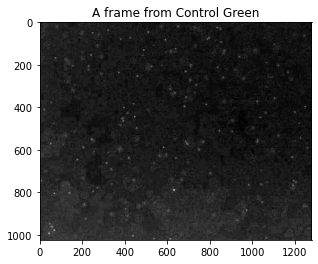

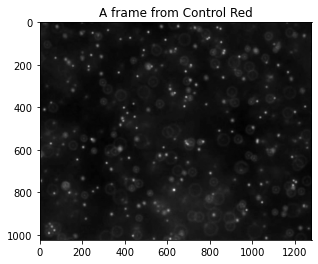

In [7]:
## Show a frame from each movie
if doing_fueled:
    plt.figure()
    plt.imshow(fueled_green[50], cmap='gray')
    plt.title('A frame from Fueled Green')
    
if doing_fueled:
    plt.figure()
    plt.imshow(fueled_red[50], cmap='gray')
    plt.title('A frame from Fueled Red')
    
if doing_control:
    plt.figure()
    plt.imshow(control_green[50], cmap='gray')
    plt.title('A frame from Control Green')
    
if doing_control:
    plt.figure()
    plt.imshow(control_red[50], cmap='gray')
    plt.title('A frame from Control Red')

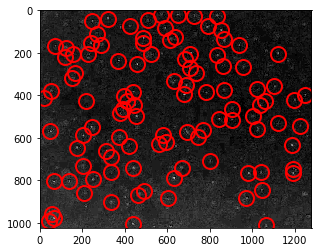

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>]], dtype=object)

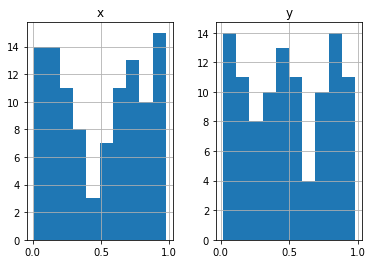

In [8]:
# Find bright spots in a frame of Fueled Green.
# featuresize must be odd.
# Read up on this in the trackpy literature.
# This needs to be updated if the particle or objective changes!!

i = 50 # Frame to search in
bright_background = False # Only true if looking for dark spots on a bright background
feature_size = 19 # Change this to find different size particles, can use ImageJ to get approximate feature size?
feature_mass_green = 375
feature_mass_red = 350

if doing_control:
    f1 = tp.locate(control_green[i], diameter=feature_size, invert=bright_background, minmass=feature_mass_green)
else:
    f1 = tp.locate(fueled_green[i], diameter=feature_size, invert=bright_background, minmass=feature_mass_green)

plt.figure()  # make a new figure
if doing_control:
    tp.annotate(f1, control_green[i])
else:
    tp.annotate(f1, fueled_green[i])

tp.subpx_bias(f1)  # for determining if particles bias a pixel (you can check before doing the whole batch)

#del f1

In [9]:
# Now that we have picked out an appropriate featuresize and settings, it's time to go through ALL the frames,
# finding the coordinates of the bright spots in each frame.
# batch already uses a loop to go through frames

time_sec_1 = time.time()
# Elapsed time 1.4 min


if doing_fueled:
    fueled_janus_coords = tp.batch(fueled_green, diameter=feature_size, invert=bright_background, minmass=feature_mass_green)
    tp.subpx_bias(fueled_janus_coords)

In [10]:
if doing_fueled:
    fueled_tracer_coords = tp.batch(fueled_red, diameter=feature_size, invert=bright_background, minmass=feature_mass_red)
    tp.subpx_bias(fueled_tracer_coords)

Frame 697: 116 features


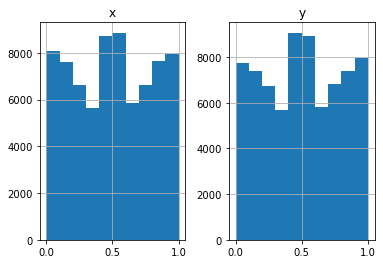

In [11]:
if doing_control:
    control_janus_coords = tp.batch(control_green, diameter=feature_size, invert=bright_background, minmass=feature_mass_green)
    tp.subpx_bias(control_janus_coords)

Frame 697: 467 features
Elapsed time 1.4577007055282594 min


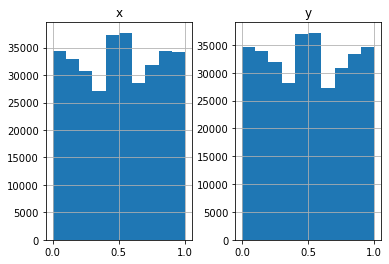

In [12]:
if doing_control:
    control_tracer_coords = tp.batch(control_red, diameter=feature_size, invert=bright_background, minmass=feature_mass_red)
    tp.subpx_bias(control_tracer_coords)
    
time_sec_2 = time.time()
elapsed_min = (time_sec_2-time_sec_1)/60.0
print("Elapsed time " + str(elapsed_min) + " min" )

# Documentation: http://soft-matter.github.io/trackpy/generated/trackpy.batch.html

# This is an implementation of the Crocker-Grier centroid-finding algorithm.
#  Crocker, J.C., Grier, D.G. http://dx.doi.org/10.1006/jcis.1996.0217

In [13]:
# Note: These particle numbers count each frame individually, not the trajectories.
if doing_fueled:
    print('Fueled Janus')
    print('Number of Frames: ' + str(len(fueled_green)))
    print('Number of Particles: ' + str(len(fueled_janus_coords)))
    print()
    print('Fueled Tracer')
    print('Number of Frames: ' + str(len(fueled_red)))
    print('Number of Particles: ' + str(len(fueled_tracer_coords)))
    print()
if doing_control:
    print('Control Janus')
    print('Number of Frames: ' + str(len(control_green)))
    print('Number of Particles: ' + str(len(control_janus_coords)))
    print()
    print('Control Tracer')
    print('Number of Frames: ' + str(len(control_red)))
    print('Number of Particles: ' + str(len(control_tracer_coords)))

Control Janus
Number of Frames: 698
Number of Particles: 73595

Control Tracer
Number of Frames: 698
Number of Particles: 328921


In [14]:
# We have just built a list of coordinates called f_coords where we have seen particles. '
# Now we want to link these together from one frame to the next 
# so we can identify the trajectory for each particle.

# Documentation: http://soft-matter.github.io/trackpy/v0.3.0/generated/trackpy.link.html

# Fastest particle velocity observed in Viva's EPJST paper was about 15 microns/sec. Search
# range should be scalable based on that upper bound.
fastest = 15 # microns / second
memory = 5
search_range = int(round(fastest/(fps * scaling)))

if doing_fueled:
    fueled_janus_unfiltered = tp.link_df(f=fueled_janus_coords, search_range=search_range, memory=memory)
    fueled_tracer_unfiltered = tp.link_df(f=fueled_tracer_coords, search_range=search_range, memory=memory)
if doing_control:
    control_janus_unfiltered = tp.link_df(f=control_janus_coords, search_range=search_range, memory=memory)
    control_tracer_unfiltered = tp.link_df(f=control_tracer_coords, search_range=search_range, memory=memory)
"""
if doing_fueled:
    del fueled_janus_coords, fueled_tracer_coords
if doing_control:
    del control_janus_coords, control_tracer_coords
"""
if doing_fueled:
    fueled_janus_unfiltered.to_pickle(movie_analysis_folder + 'fueled_janus_unfiltered.pkl')
    fueled_tracer_unfiltered.to_pickle(movie_analysis_folder + 'fueled_tracer_unfiltered.pkl')
if doing_control:
    control_janus_unfiltered.to_pickle(movie_analysis_folder + 'control_janus_unfiltered.pkl')
    control_tracer_unfiltered.to_pickle(movie_analysis_folder + 'control_tracer_unfiltered.pkl')

print("The search range was {0} pixels.".format(search_range))

Frame 697: 467 trajectories present.
The search range was 7 pixels.


In [15]:
## Plot unfiltered trajectories

if do_slow_stuff:
    print('Trajectories before filtering')
    if doing_fueled:
        print('Fueled Janus')
        fueled_janus_trajectory_plot = tp.plot_traj(fueled_janus_unfiltered,
                                       superimpose = fueled_green[int(len(fueled_green)/2)], label=False)

        print('Fueled Tracer')
        fueled_tracer_trajectory_plot = tp.plot_traj(fueled_tracer_unfiltered,
                                       superimpose = fueled_red[int(len(fueled_red)/2)], label=False)

    if doing_control:
        print('Control Janus')
        control_janus_trajectory_plot = tp.plot_traj(control_janus_unfiltered,
                                       superimpose = control_green[int(len(control_green)/2)], label=False)

        print('Control Tracer')
        control_tracer_trajectory_plot = tp.plot_traj(control_tracer_unfiltered,
                                       superimpose = control_red[int(len(control_red)/2)], label=False)

In [16]:
# Only keep trajectories that last at least this many frames
filter_length = 10

if doing_fueled:
    fueled_janus = tp.filter_stubs(fueled_janus_unfiltered, filter_length)
    fueled_tracer = tp.filter_stubs(fueled_tracer_unfiltered, filter_length)
if doing_control:
    control_janus = tp.filter_stubs(control_janus_unfiltered, filter_length)
    control_tracer = tp.filter_stubs(control_tracer_unfiltered, filter_length)

## Save the trajectories
if doing_fueled:
    fueled_janus.to_pickle(movie_analysis_folder + 'fueled_janus.pkl')
    fueled_tracer.to_pickle(movie_analysis_folder + 'fueled_tracer.pkl')
if doing_control:
    control_janus.to_pickle(movie_analysis_folder + 'control_janus.pkl')
    control_tracer.to_pickle(movie_analysis_folder + 'control_tracer.pkl')

# Compare the number of particles in the unfiltered and filtered data.
if doing_fueled:
    print('Fueled Janus')
    print('Before:', fueled_janus_unfiltered['particle'].nunique())
    print('After:', fueled_janus['particle'].nunique())
    metric4_fueled_janus = fueled_janus['particle'].nunique()
    print()
    print('Fueled Tracer')
    print('Before:', fueled_tracer_unfiltered['particle'].nunique())
    print('After:', fueled_tracer['particle'].nunique())
    metric4_fueled_tracer = fueled_tracer['particle'].nunique()
    print()
if doing_control:
    print('Control Janus')
    print('Before:', control_janus_unfiltered['particle'].nunique())
    print('After:', control_janus['particle'].nunique())
    metric4_control_janus = control_janus['particle'].nunique()
    print()
    print('Control Tracer')
    print('Before:', control_tracer_unfiltered['particle'].nunique())
    print('After:', control_tracer['particle'].nunique())
    metric4_control_tracer = control_tracer['particle'].nunique()
"""
if doing_fueled:
    del fueled_janus_unfiltered, fueled_tracer_unfiltered
if doing_control:
    del control_janus_unfiltered, control_tracer_unfiltered
"""

Control Janus
Before: 6653
After: 1075

Control Tracer
Before: 31550
After: 6140


'\nif doing_fueled:\n    del fueled_janus_unfiltered, fueled_tracer_unfiltered\nif doing_control:\n    del control_janus_unfiltered, control_tracer_unfiltered\n'

In [17]:
if do_slow_stuff:
    if doing_fueled:
        print('Fueled Janus')
        fueled_janus_trajectory_plot = tp.plot_traj(fueled_janus,
                                       superimpose = fueled_green[int(len(fueled_green)/2)], label=False)

        print('Fueled Tracer')
        fueled_tracer_trajectory_plot = tp.plot_traj(fueled_tracer,
                                       superimpose = fueled_red[int(len(fueled_red)/2)], label=False)

    if doing_control:
        print('Control Janus')
        control_janus_trajectory_plot = tp.plot_traj(control_janus,
                                       superimpose = control_green[int(len(control_green)/2)], label=False)

        print('Control Tracer')
        control_tracer_trajectory_plot = tp.plot_traj(control_tracer,
                                       superimpose = control_red[int(len(control_red)/2)], label=False)

In [18]:
try:
    axes().set_aspect('equal', 'datalim') 
except:
    pass

if do_slow_stuff:
    if doing_fueled:
        print('Fueled Janus')
        plt.axis('equal')
        fueled_janus_trajectory_plot = tp.plot_traj(fueled_janus, mpp=scaling)

        print('Fueled Tracer')
        plt.axis('equal')
        fueled_tracer_trajectory_plot = tp.plot_traj(fueled_tracer, mpp=scaling)

    if doing_control:
        print('Control Janus')
        plt.axis('equal')
        control_janus_trajectory_plot = tp.plot_traj(control_janus, mpp=scaling)

        print('Control Tracer')
        plt.axis('equal')
        control_tracer_trajectory_plot = tp.plot_traj(control_tracer, mpp=scaling)

In [19]:
# Rotational drift subtraction starts here. First we need to define a bunch of functions.

## concatenate a new numerical column to a matrix
def put_z_position_in_matrix(mat2D, z=0):
    z_position = np.zeros(len(mat2D)) + z
    z_position = np.matrix(z_position)
    
    mat3D = np.concatenate((mat2D.T, z_position))
    mat3D = mat3D.T
    
    return mat3D

## Check to see if dataframe has z column; otherwise assume z=0.
def get_3D_matrix_from_dataframe(df, xlabel='x',ylabel='y',zlabel='z'):
    try:
        matrix = np.mat(df[[xlabel,ylabel,zlabel]])
    except KeyError:
        matrix = np.mat(df[[xlabel,ylabel]])
        matrix = put_z_position_in_matrix(matrix,0)
        
    return matrix

## The variable A_3D will be a matrix consisting of 
## all coordinates in frame i 
## whose particle is also tracked in frame f.

## The variable B_3D will be a matrix consisting of 
## all coordinates in frame i 
## whose particle is also tracked in frame f.

## This function currently assumes the particles tracked in the image frame 
## are all at the same z.

def matrices_from_dataframe(t1, framei, framef=None, z=0):
    
    # set default for final frame
    if framef == None:
        framef = framei+1
    
    # an inner merge will drop any rows for 
    # particles that are not in both frames 
    AB = pd.merge(t1[t1['frame'] == framei], 
                  t1[t1['frame'] == framef], 
                  how='inner', 
                  on='particle',
                  suffixes=('_i','_f'))

    # Pull out the coordinates and convert to matrices.
    # If z positions are not available, they are set to zero.
    A_3D = get_3D_matrix_from_dataframe(AB, xlabel='x_i',ylabel='y_i',zlabel='z_i')
    B_3D = get_3D_matrix_from_dataframe(AB, xlabel='x_f',ylabel='y_f',zlabel='z_f')
    
    assert len(A_3D) == len(B_3D)
    
    return A_3D, B_3D


## Given a matrix B which 
## has experienced rotation R and translation t, 
## undo that transformation.
def rotational_drift_subtraction(B, R, t):
    n = len(B)
    drift_subtracted = R.T * (B.T - np.tile(t,(1,n)))
    drift_subtracted = drift_subtracted.T
    
    return drift_subtracted

## This function is copied from http://nghiaho.com/uploads/code/rigid_transform_3D.py_
# Input: expects Nx3 matrix of points
# Returns R,t
# R = 3x3 rotation matrix
# t = 3x1 column vector

def rigid_transform_3D(A, B):
    assert len(A) == len(B)

    N = A.shape[0]; # total points

    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    
    # centre the points
    AA = A - np.tile(centroid_A, (N, 1))
    BB = B - np.tile(centroid_B, (N, 1))

    # dot is matrix multiplication for array
    H = np.transpose(AA) * BB

    U, S, Vt = np.linalg.svd(H)

    R = Vt.T * U.T

    # special reflection case
    if np.linalg.det(R) < 0:
       print("Reflection detected")
       Vt[2,:] *= -1
       R = Vt.T * U.T

    t = -R*centroid_A.T + centroid_B.T

    #print t

    return R, t

# Calculate the axis and angle of rotation for a given rotation matrix R
def axis_angle(R):
    h = R[2,1]
    f = R[1,2]
    c = R[0,2]
    g = R[2,0]
    d = R[1,0]
    b = R[0,1]
    
    # axis of rotation
    axis = [h-f, c-g, d-b]
    
    # angle of rotation, in radians
    angle = np.arccos((np.trace(R) - 1)/2)
    
    ## different way to calculate angle
    # axis_length = np.linalg.norm(axis)
    # angle = np.arcsin(axis_length/2) 
    
    return np.mat(axis), angle # in radians

"""
Unused function.
"""
def print_head(matrix, max_printable_length = 10):
    if len(matrix)>max_printable_length:
        print(matrix[0:max_printable_length])
        print("...")
    else:
        print(matrix)

In [20]:
"""
Calculates, plots, and optionally subtracts translational and rotational COM drift of an ensemble of particles.

@param janus - dataframe of janus particle positions over time
@param tracer - dataframe of tracer particle positions over time
@param do_drift_subtraction - determine if you want drift subtraction to be done

@return dataframes of janus and tracer particles post-drift subtraction
"""
def drift_subtract(janus, tracer, do_drift_subtraction = True):
    # Before combining janus and tracer into particles, we must make them not have conflicting particle numbers.
    particles = tracer.copy()
    particles['particle'] += janus['particle'].max() + 1
    particles = particles.append(janus) # DEPRECATED! Use pandas.concat instead.
    
    if do_drift_subtraction:
        janus_nodrift = 0
        del janus_nodrift
        tracer_nodrift = 0
        del tracer_nodrift
    prev_frame = None
    R_list = []
    t_list = []
    x_drifts = []
    y_drifts = []
    z_drifts = []
    axis_list = []
    angle_list = []
    frame_list = []
    verbose = False

    labelx = 'x'
    labely = 'y'
    labelz = 'z'
    transformed_str = '_drift_subtracted'
    labelx2 = labelx + transformed_str
    labely2 = labely + transformed_str
    labelz2 = labelz + transformed_str
    labelnote = 'relative_to_frame'
    
    for current_frame in np.sort(particles.frame.unique()):
        if verbose:
            print("Frame ", current_frame)

        if prev_frame is None:
            relative_to = current_frame
            prev_frame = current_frame
            continue;  # skip first frame

        assert prev_frame is not None

        # A is a shorthand for the previous frame.
        # B is a shorthand for the current frame.

        # Get raw coordinates from current frame and previous frame
        A_3D, B_3D = matrices_from_dataframe(particles, prev_frame, current_frame)

        # Figure out the transformation that occured between frames
        ret_R, ret_t = rigid_transform_3D(A_3D, B_3D)

        # Save a copy of the transformation
        R_list.append(ret_R)
        t_list.append(ret_t)
        x_drifts.append(np.array(ret_t)[0][0])
        y_drifts.append(np.array(ret_t)[1][0])
        z_drifts.append(np.array(ret_t)[2][0])
        current_axis,current_angle = axis_angle(ret_R)
        axis_list.append(current_axis)
        angle_list.append(current_angle)
        frame_list.append(current_frame)

        if do_drift_subtraction:
            ## Do the rotational drift subtraction.
            ## I need to do this with all particles in current frame, 
            ## not just the ones that also appear in previous frame.

            B_dataframe_janus = janus[janus['frame'] == current_frame].copy()
            B_janus = get_3D_matrix_from_dataframe(B_dataframe_janus)
            
            B_dataframe_tracer = tracer[tracer['frame'] == current_frame].copy()
            B_tracer = get_3D_matrix_from_dataframe(B_dataframe_tracer)

            for R,t in zip(reversed(R_list),reversed(t_list)):
                if verbose:
                    print("undoing transformation")
                    print(R)
                # We use the same R and t to drift subtract both types of particles, 
                # assuming both are in the same overall drifty current.
                B_janus = rotational_drift_subtraction(B_janus, R, t)
                B_tracer = rotational_drift_subtraction(B_tracer, R, t)
                # This is rather brute force, 
                # but I wanted to make sure I'm correct first.
                # The better thing to do is probably to calculate 
                # the total transformation before transforming the coordinates.

            ## Record the drift-subtracted coordinates
            # (i.e. Put the transformed data in the dataframe)

            x_sub_data_janus = np.array(B_janus[:,0]).T[0]
            y_sub_data_janus = np.array(B_janus[:,1]).T[0]
            z_sub_data_janus = np.array(B_janus[:,2]).T[0]
            
            x_sub_data_tracer = np.array(B_tracer[:,0]).T[0]
            y_sub_data_tracer = np.array(B_tracer[:,1]).T[0]
            z_sub_data_tracer = np.array(B_tracer[:,2]).T[0]

            B_dataframe_janus[labelx2]=x_sub_data_janus
            B_dataframe_janus[labely2]=y_sub_data_janus
            
            B_dataframe_tracer[labelx2]=x_sub_data_tracer
            B_dataframe_tracer[labely2]=y_sub_data_tracer

            # Assumes janus and tracer either both have z data or both don't
            if not np.array_equal(z_sub_data_janus, np.zeros_like(z_sub_data_janus)):
                ## Not tested with a z column
                B_dataframe_janus[labelz2]=z_sub_data_janus
                B_dataframe_tracer[labelz2]=z_sub_data_tracer
                num_new_cols = 4
            else:
                ## no z data
                num_new_cols = 3

            B_dataframe_janus[labelnote] = relative_to
            B_dataframe_tracer[labelnote] = relative_to

            try:
                janus_nodrift = pd.concat([janus_nodrift, B_dataframe_janus])
                tracer_nodrift = pd.concat([tracer_nodrift, B_dataframe_tracer])
            except NameError:
                # Initialize particles_nodrift
                janus_nodrift = B_dataframe_janus.copy()
                tracer_nodrift = B_dataframe_tracer.copy()

        prev_frame = current_frame

        # end loop

    ## Rename some columns in particles_nodrift
    if do_drift_subtraction:
        # Put the new columns up front
        janus_cols = janus_nodrift.columns.tolist()
        janus_cols = janus_cols[-num_new_cols:]+janus_cols[:-num_new_cols]
        janus_nodrift = janus_nodrift.reindex(columns=janus_cols)
        
        tracer_cols = tracer_nodrift.columns.tolist()
        tracer_cols = tracer_cols[-num_new_cols:]+tracer_cols[:-num_new_cols]
        tracer_nodrift = tracer_nodrift.reindex(columns=tracer_cols)

        ## Rename raw columns
        janus_nodrift = janus_nodrift.rename(index=str,
                       columns={labelx: labelx + "_raw", 
                                labely: labely + "_raw"})
        janus_nodrift = janus_nodrift.rename(index=str,
                       columns={labelx2: labelx,
                                labely2: labely})
        
        tracer_nodrift = tracer_nodrift.rename(index=str,
                       columns={labelx: labelx + "_raw", 
                                labely: labely + "_raw"})
        tracer_nodrift = tracer_nodrift.rename(index=str,
                       columns={labelx2: labelx,
                                labely2: labely})

        if num_new_cols == 4:
            ## Not tested with a z column
            janus_nodrift = janus_nodrift.rename(index=str, 
                           columns={labelz: labelz + "_raw"})
            janus_nodrift = janus_nodrift.rename(index=str,
                           columns={labelz2: labelz})
            
            tracer_nodrift = tracer_nodrift.rename(index=str, 
                           columns={labelz: labelz + "_raw"})
            tracer_nodrift = tracer_nodrift.rename(index=str,
                           columns={labelz2: labelz})
            
    # Subplots: https://matplotlib.org/stable/tutorials/introductory/pyplot.html
    plt.subplot(211)        
    plt.plot(frame_list,angle_list)
    plt.title(movie_name + '\nAngular drift\n')
    plt.xlabel('Frame')
    plt.ylabel('Angular drift [radians]')
    
    plt.subplot(212)
    plt.plot(frame_list,x_drifts, label="x")
    plt.plot(frame_list,y_drifts, label="y")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(movie_name + '\nTranslational drift\n')
    plt.xlabel('Frame')
    plt.ylabel('Translational drift [pixels]')
    
    return janus_nodrift, tracer_nodrift

C:\Users\rsmolars\AppData\Local\Temp\ipykernel_10676\1913864799.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  particles = particles.append(janus) # DEPRECATED! Use pandas.concat instead.


Elapsed time 0.3043865998586019 min


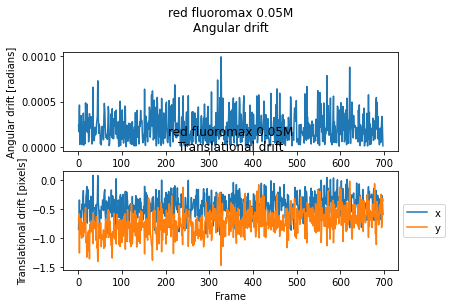

In [21]:
time_sec_3 = time.time()
# Elapsed time 0.3 min

# Rotational drift subtraction continued. Now we are actually doing the subtraction, not just defining things.

if doing_fueled:
    fueled_janus_nodrift, fueled_tracer_nodrift = drift_subtract(fueled_janus, fueled_tracer)
if doing_control:
    control_janus_nodrift, control_tracer_nodrift = drift_subtract(control_janus, control_tracer)

time_sec_4 = time.time()
elapsed_min = (time_sec_4-time_sec_3)/60.0
print("Elapsed time " + str(elapsed_min) + " min" )
    
if doing_fueled:
    fueled_janus_nodrift.to_pickle(movie_analysis_folder + 'fueled_janus_nodrift.pkl')
    fueled_tracer_nodrift.to_pickle(movie_analysis_folder + 'fueled_tracer_nodrift.pkl')
if doing_control:
    control_janus_nodrift.to_pickle(movie_analysis_folder + 'control_janus_nodrift.pkl')
    control_tracer_nodrift.to_pickle(movie_analysis_folder + 'control_tracer_nodrift.pkl')

<Figure size 432x288 with 0 Axes>

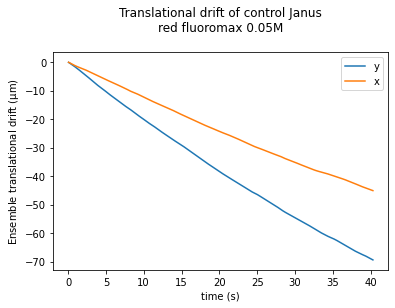

<Figure size 432x288 with 0 Axes>

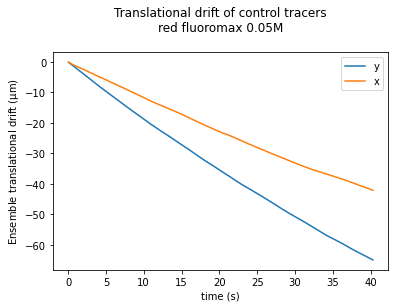

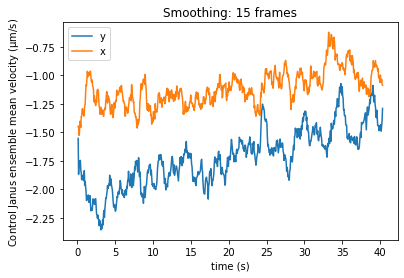

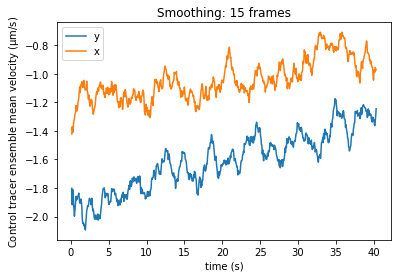

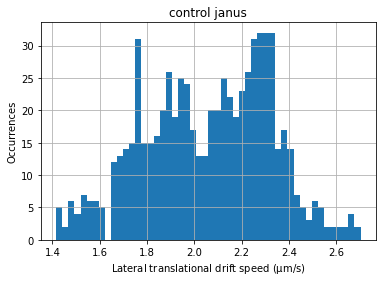

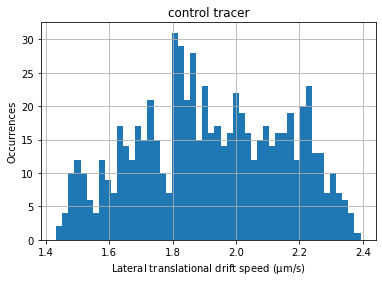

In [22]:
## View translational drift (though we use rotational drift for drift
## subtraction)
smoothing = 15 # frames

if doing_control:
    drift_control_janus = tp.compute_drift(control_janus, smoothing)*scaling
    drift_control_tracer = tp.compute_drift(control_tracer, smoothing)*scaling

    # Convert from frames to seconds
    drift_control_janus.index = drift_control_janus.index /fps
    drift_control_tracer.index = drift_control_tracer.index /fps
    drift_control_janus.index.name = 'time (s)'
    drift_control_tracer.index.name = 'time (s)'

    plt.figure()
    drift_control_janus.plot(grid=False)
    plt.title('Translational drift of control Janus\n' + movie_name + '\n')
    plt.ylabel('Ensemble translational drift ($\mathrm{\mu}$m)')
    #plt.xlabel('seconds')

    plt.figure()
    drift_control_tracer.plot(grid=False)
    plt.title('Translational drift of control tracers\n' + movie_name + '\n')
    plt.ylabel('Ensemble translational drift ($\mathrm{\mu}$m)')

    motion_control_janus = drift_control_janus.diff()
    velocity_control_janus_df = (drift_control_janus.diff()/ (1/fps))
    velocity_control_janus_df.plot()
    plt.ylabel("Control Janus ensemble mean velocity ($\mathrm{\mu}$m/s)")
    plt.title('Smoothing: ' + str(smoothing) + " frames")


    motion_control_tracer = drift_control_tracer.diff()
    velocity_control_tracer_df = (drift_control_tracer.diff()/ (1/fps))
    velocity_control_tracer_df.plot()
    plt.ylabel("Control tracer ensemble mean velocity ($\mathrm{\mu}$m/s)")
    plt.title('Smoothing: ' + str(smoothing) + " frames")

    ## Add speed to dataframes
    velocity_control_janus_df['speed'] = sqrt(velocity_control_janus_df.x**2 + velocity_control_janus_df.y**2)
    velocity_control_tracer_df['speed'] = sqrt(velocity_control_tracer_df.x**2 + velocity_control_tracer_df.y**2)

    plt.figure()
    velocity_control_janus_df.speed.hist(bins=50, label="control janus")
    plt.xlabel("Lateral translational drift speed ($\mathrm{\mu}$m/s)")
    plt.ylabel("Occurrences")
    plt.title("control janus")

    plt.figure()
    velocity_control_tracer_df.speed.hist(bins=50, label="control tracer")
    plt.xlabel("Lateral translational drift speed ($\mathrm{\mu}$m/s)")
    plt.ylabel("Occurrences")
    plt.title("control tracer")

if doing_fueled:
    drift_fueled_janus = tp.compute_drift(fueled_janus, smoothing)*scaling
    drift_fueled_tracer = tp.compute_drift(fueled_tracer, smoothing)*scaling

    # Convert from frames to seconds
    drift_fueled_janus.index = drift_fueled_janus.index /fps
    drift_fueled_tracer.index = drift_fueled_tracer.index /fps
    drift_fueled_janus.index.name = 'time (s)'
    drift_fueled_tracer.index.name = 'time (s)'

    plt.figure()
    drift_fueled_janus.plot(grid=False)
    plt.title('Translational drift of fueled Janus\n' + movie_name + '\n')
    plt.ylabel('Ensemble translational drift ($\mathrm{\mu}$m)')

    plt.figure()
    drift_fueled_tracer.plot(grid=False)
    plt.title('Translational drift of fueled tracers\n' + movie_name + '\n')
    plt.ylabel('Ensemble translational drift ($\mathrm{\mu}$m)')

    motion_fueled_janus = drift_fueled_janus.diff()
    velocity_fueled_janus_df = (drift_fueled_janus.diff()/ (1/fps))
    velocity_fueled_janus_df.plot()
    plt.ylabel("fueled Janus ensemble mean velocity ($\mathrm{\mu}$m/s)")
    plt.title('Smoothing: ' + str(smoothing) + " frames")

    motion_fueled_tracer = drift_fueled_tracer.diff()
    velocity_fueled_tracer_df = (drift_fueled_tracer.diff()/ (1/fps))
    velocity_fueled_tracer_df.plot()
    plt.ylabel("fueled tracer ensemble mean velocity ($\mathrm{\mu}$m/s)")
    plt.title('Smoothing: ' + str(smoothing) + " frames")

    ## Add speed to dataframes
    velocity_fueled_janus_df['speed'] = sqrt(velocity_fueled_janus_df.x**2 + velocity_fueled_janus_df.y**2)
    velocity_fueled_tracer_df['speed'] = sqrt(velocity_fueled_tracer_df.x**2 + velocity_fueled_tracer_df.y**2)

    plt.figure()
    velocity_fueled_janus_df.speed.hist(bins=50, label="fueled janus")
    plt.xlabel("Lateral translational drift speed ($\mathrm{\mu}$m/s)")
    plt.ylabel("Occurrences")
    plt.title("fueled janus")

    plt.figure()
    velocity_fueled_tracer_df.speed.hist(bins=50, label="fueled tracer")
    plt.xlabel("Lateral translational drift speed ($\mathrm{\mu}$m/s)")
    plt.ylabel("Occurrences")
    plt.title("fueled tracer")

In [23]:
if do_slow_stuff:
    if doing_fueled:
        plt.axis('equal')
        plt.title(movie_name + '\n Fueled Janus trajectories with drift subtraction\n')
        ax = tp.plot_traj(fueled_janus_nodrift, legend=False)

    if doing_fueled:
        plt.axis('equal')
        plt.title(movie_name + '\n Fueled Tracer trajectories with drift subtraction\n')
        ax = tp.plot_traj(fueled_tracer_nodrift, legend=False)

    if doing_control:
        plt.axis('equal')
        plt.title(movie_name + '\n Control Janus trajectories with drift subtraction\n')
        ax = tp.plot_traj(control_janus_nodrift, legend=False)

    if doing_control:
        plt.axis('equal')
        plt.title(movie_name + '\n Control Tracer trajectories with drift subtraction\n')
        ax = tp.plot_traj(control_tracer_nodrift, legend=False)

In [24]:
if doing_fueled:
    fueled_janus_imsd = tp.imsd(fueled_janus_nodrift, mpp=scaling, fps=fps, max_lagtime=1000)
    fueled_tracer_imsd = tp.imsd(fueled_tracer_nodrift, mpp=scaling, fps=fps, max_lagtime=1000)
if doing_control:
    control_janus_imsd = tp.imsd(control_janus_nodrift, mpp=scaling, fps=fps, max_lagtime=1000)
    control_tracer_imsd = tp.imsd(control_tracer_nodrift, mpp=scaling, fps=fps, max_lagtime=1000)

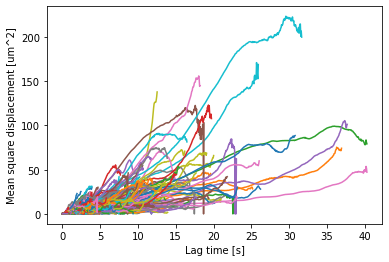

In [25]:
plt.plot(control_janus_imsd);
plt.ylabel("Mean square displacement [um^2]");
plt.xlabel("Lag time [s]");

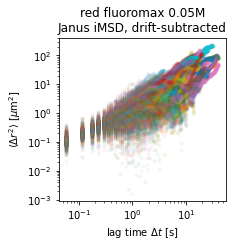

In [26]:
fig, ax = plt.subplots()
if doing_fueled:
    plt.plot(fueled_janus_imsd, 'r-', alpha=0.15)
if doing_control:
    plt.plot(control_janus_imsd, '.', alpha=0.05)

ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $\Delta{}t$ [s]')
ax.set_xscale('log')
ax.set_yscale('log')
fig.set_size_inches(3,3)
plt.title(movie_name + '\nJanus iMSD, drift-subtracted');

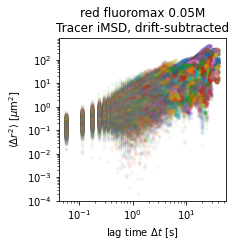

In [27]:
fig, ax = plt.subplots()
if doing_fueled:
    ax.plot(fueled_tracer_imsd, 'r-', alpha=0.15)
if doing_control:
    ax.plot(control_tracer_imsd, '.', alpha=0.05)

ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $\Delta{}t$ [s]')
ax.set_xscale('log')
ax.set_yscale('log')
fig.set_size_inches(3,3)
plt.title(movie_name + '\nTracer iMSD, drift-subtracted');

In [28]:
if doing_fueled:
    fueled_janus_imsd_drifty = tp.imsd(fueled_janus, mpp=scaling, fps=fps, max_lagtime=1000)
    fueled_tracer_imsd_drifty = tp.imsd(fueled_tracer, mpp=scaling, fps=fps, max_lagtime=1000)
if doing_control:
    control_janus_imsd_drifty = tp.imsd(control_janus, mpp=scaling, fps=fps, max_lagtime=1000)
    control_tracer_imsd_drifty = tp.imsd(control_tracer, mpp=scaling, fps=fps, max_lagtime=1000)

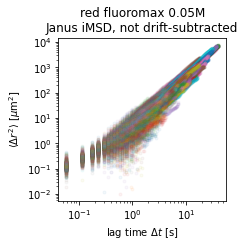

In [29]:
fig, ax = plt.subplots()
if doing_fueled:
    ax.plot(fueled_janus_imsd_drifty, 'r-', alpha=0.15)
if doing_control:
    ax.plot(control_janus_imsd_drifty, '.', alpha=0.05)

ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $\Delta{}t$ [s]')
ax.set_xscale('log')
ax.set_yscale('log')
fig.set_size_inches(3,3)
plt.title(movie_name + '\nJanus iMSD, not drift-subtracted');

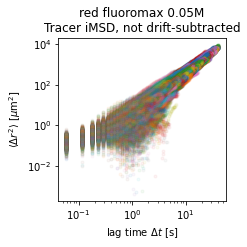

In [30]:
fig, ax = plt.subplots()
if doing_fueled:
    ax.plot(fueled_tracer_imsd_drifty, 'r-', alpha=0.15)
if doing_control:
    ax.plot(control_tracer_imsd_drifty, '.', alpha=0.05)

ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $\Delta{}t$ [s]')
ax.set_xscale('log')
ax.set_yscale('log')
fig.set_size_inches(3,3)
plt.title(movie_name + '\nTracer iMSD, not drift-subtracted');


In [31]:
emsd_max_lagtime = 100
if doing_fueled:
    fueled_janus_emsd = tp.emsd(fueled_janus_nodrift, mpp=scaling, fps=fps, max_lagtime = emsd_max_lagtime).replace(0, np.nan).dropna()
    fueled_tracer_emsd = tp.emsd(fueled_tracer_nodrift, mpp=scaling, fps=fps, max_lagtime = emsd_max_lagtime).replace(0, np.nan).dropna()
if doing_control:
    control_janus_emsd = tp.emsd(control_janus_nodrift, mpp=scaling, fps=fps, max_lagtime = emsd_max_lagtime).replace(0, np.nan).dropna()
    control_tracer_emsd = tp.emsd(control_tracer_nodrift, mpp=scaling, fps=fps, max_lagtime = emsd_max_lagtime).replace(0, np.nan).dropna()

C:\Users\rsmolars\Anaconda3\lib\site-packages\trackpy\motion.py:235: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = msds.mul(msds['N'], axis=0).mean(level=1)  # weighted average
C:\Users\rsmolars\Anaconda3\lib\site-packages\trackpy\motion.py:236: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = results.div(msds['N'].mean(level=1), axis=0)  # weights normalized
C:\Users\rsmolars\Anaconda3\lib\site-packages\trackpy\motion.py:235: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  re

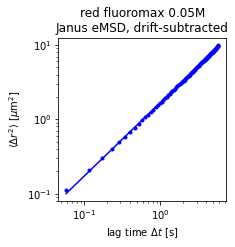

In [32]:
fig, ax1 = plt.subplots()

if doing_fueled:
    fueled_janus_fit = tp.utils.fit_powerlaw(fueled_janus_emsd, plot = False)
    fueled_janus_fit_x = [1/fps, (1/fps) * len(fueled_janus_emsd)]
    fueled_janus_fit_y = [fueled_janus_fit.A[0] * np.power(fueled_janus_fit_x[0], fueled_janus_fit.n[0]),
                         fueled_janus_fit.A[0] * np.power(fueled_janus_fit_x[1], fueled_janus_fit.n[0])]
    
if doing_control:
    control_janus_fit = tp.utils.fit_powerlaw(control_janus_emsd, plot = False)
    control_janus_fit_x = [1/fps, (1/fps) * len(control_janus_emsd)]
    control_janus_fit_y = [control_janus_fit.A[0] * np.power(control_janus_fit_x[0], control_janus_fit.n[0]),
                         control_janus_fit.A[0] * np.power(control_janus_fit_x[1], control_janus_fit.n[0])]

if doing_fueled:
    fueled_janus_emsd.plot(loglog=True, figsize = [3,3], style = 'r.',  grid=False, ax=ax1)
    plt.plot(fueled_janus_fit_x, fueled_janus_fit_y, 'r')

if doing_control:
    control_janus_emsd.plot(loglog=True, figsize = [3,3], style = 'b.',  grid=False, ax=ax1)
    plt.plot(control_janus_fit_x, control_janus_fit_y, 'b')

ax1.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]', xlabel='lag time $\Delta{}t$ [s]')
plt.title(movie_name + '\nJanus eMSD, drift-subtracted')

plt.savefig(os.path.join(movie_analysis_folder, 'janus_eMSDs.png'))

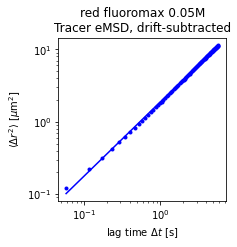

In [33]:
fig, ax1 = plt.subplots()

if doing_fueled:
    fueled_tracer_fit = tp.utils.fit_powerlaw(fueled_tracer_emsd, plot = False)
    fueled_tracer_fit_x = [1/fps, (1/fps) * len(fueled_tracer_emsd)]
    fueled_tracer_fit_y = [fueled_tracer_fit.A[0] * np.power(fueled_tracer_fit_x[0], fueled_tracer_fit.n[0]),
                         fueled_tracer_fit.A[0] * np.power(fueled_tracer_fit_x[1], fueled_tracer_fit.n[0])]

if doing_control:
    control_tracer_fit = tp.utils.fit_powerlaw(control_tracer_emsd, plot = False)
    control_tracer_fit_x = [1/fps, (1/fps) * len(control_tracer_emsd)]
    control_tracer_fit_y = [control_tracer_fit.A[0] * np.power(control_tracer_fit_x[0], control_tracer_fit.n[0]),
                         control_tracer_fit.A[0] * np.power(control_tracer_fit_x[1], control_tracer_fit.n[0])]

if doing_fueled:
    fueled_tracer_emsd.plot(loglog=True, figsize = [3,3], style = 'r.',  grid=False, ax=ax1)
    plt.plot(fueled_tracer_fit_x, fueled_tracer_fit_y, 'r')

if doing_control:
    control_tracer_emsd.plot(loglog=True, figsize = [3,3], style = 'b.',  grid=False, ax=ax1)
    plt.plot(control_tracer_fit_x, control_tracer_fit_y, 'b')

ax1.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]', xlabel='lag time $\Delta{}t$ [s]')
plt.title(movie_name + '\nTracer eMSD, drift-subtracted')

plt.savefig(os.path.join(movie_analysis_folder, 'tracer_eMSDs.png'))

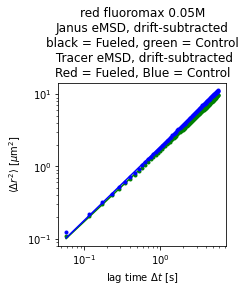

In [34]:
fig, ax1 = plt.subplots()

if doing_fueled:
    fueled_janus_emsd.plot(loglog=True, figsize = [3,3], style = 'k.',  grid=False, ax=ax1, label="fueled Janus")
    plt.plot(fueled_janus_fit_x, fueled_janus_fit_y, 'k')

if doing_control:
    control_janus_emsd.plot(loglog=True, figsize = [3,3], style = 'g.',  grid=False, ax=ax1, label="control Janus")
    plt.plot(control_janus_fit_x, control_janus_fit_y, 'g')

if doing_fueled:
    fueled_tracer_emsd.plot(loglog=True, figsize = [3,3], style = 'r.',  grid=False, ax=ax1, label="fueled Tracer")
    plt.plot(fueled_tracer_fit_x, fueled_tracer_fit_y, 'r')

if doing_control:
    control_tracer_emsd.plot(loglog=True, figsize = [3,3], style = 'b.',  grid=False, ax=ax1, label="control Tracer")
    plt.plot(control_tracer_fit_x, control_tracer_fit_y, 'b')

ax1.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]', xlabel='lag time $\Delta{}t$ [s]')
plt.title(movie_name + 
          '\nJanus eMSD, drift-subtracted\nblack = Fueled, green = Control'
          + '\n Tracer eMSD, drift-subtracted\nRed = Fueled, Blue = Control')


plt.savefig(os.path.join(movie_analysis_folder, 'janus+tracer_eMSDs.pdf'))



In [35]:
if doing_fueled:
    print('Fueled Janus: n =', fueled_janus_fit.values[0,0], 'A =' , fueled_janus_fit.values[0,1])
    print('Fueled Tracers: n =', fueled_tracer_fit.values[0,0], 'A =' , fueled_tracer_fit.values[0,1])
if doing_control:
    print('Control Janus: n =', control_janus_fit.values[0,0], 'A =' , control_janus_fit.values[0,1])
    print('Control Tracers: n =', control_tracer_fit.values[0,0], 'A =' , control_tracer_fit.values[0,1])

if doing_fueled:
    fueled_janus_emsd.to_csv(os.path.join(movie_analysis_folder, "fueled_janus_emsd.csv"))
    fueled_tracer_emsd.to_csv(os.path.join(movie_analysis_folder, "fueled_janus_emsd.csv"))
if doing_control:
    control_janus_emsd.to_csv(os.path.join(movie_analysis_folder, "fueled_janus_emsd.csv"))
    control_tracer_emsd.to_csv(os.path.join(movie_analysis_folder, "fueled_janus_emsd.csv"))

Control Janus: n = 0.9904084558978744 A = 1.678647234872021
Control Tracers: n = 1.0223692389331545 A = 1.8757055780875316


C:\Users\rsmolars\Anaconda3\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


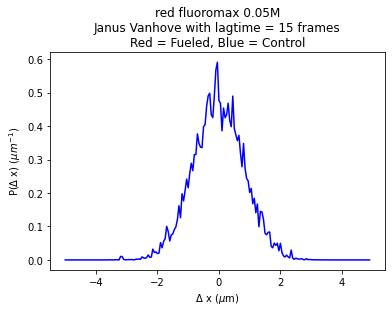

In [36]:
# Based on my previous code, I suspect the commands will be something like:

vanhove_lagtime = 15 # Measured in frames
vanhove_max_x = 5
binwidth = 0.05

## reorder tracks by frame number
if doing_fueled:
    tracksbyframe_fueled_janus = fueled_janus_nodrift.set_index(['frame','particle'])['x'].unstack()
if doing_control:
    tracksbyframe_control_janus = control_janus_nodrift.set_index(['frame','particle'])['x'].unstack()
binsequence=np.arange(-vanhove_max_x,vanhove_max_x,binwidth)
## This makes a histogram of how far the particles traveled
#    You can choose the lagtime
if doing_fueled:
    trackshist_fueled_janus_lg6 = tp.motion.vanhove(tracksbyframe_fueled_janus, lagtime = vanhove_lagtime, mpp =
    scaling,bins = binsequence, ensemble = True)
if doing_control:
    trackshist_control_janus_lg6 = tp.motion.vanhove(tracksbyframe_control_janus, lagtime = vanhove_lagtime, mpp =
    scaling,bins = binsequence, ensemble = True)

"""
if doing_fueled:
    del tracksbyframe_fueled_janus
if doing_control:
    del tracksbyframe_control_janus
del binsequence
"""
"""
Normalizes histogram data so that the sum of probabilities is one.

@param histdata - the starting histogram

@return the normalized histogram of probabilites
"""
def manualnorm(histdata):
     return (1/(histdata.sum()*binwidth))*histdata
if doing_fueled:
    trackshist_fueled_janus_lg6_norm = manualnorm(trackshist_fueled_janus_lg6)
if doing_control:
    trackshist_control_janus_lg6_norm = manualnorm(trackshist_control_janus_lg6)
if doing_fueled:
    trackshist_fueled_janus_lg6_norm.plot(color = 'red')
if doing_control:
    trackshist_control_janus_lg6_norm.plot(color = 'blue')
plt.title(movie_name + '\nJanus Vanhove with lagtime = ' + str(vanhove_lagtime)
          + ' frames\nRed = Fueled, Blue = Control')
plt.ylabel('P($\Delta$ x) ($\mu m^{-1}$)')
plt.xlabel('$\Delta$ x ($\mu$m)');

In [37]:
"""
Outputs f(x) where f is a Gaussian curve.

@param x - the independent variable
@param a - Gaussian amplitude
@param b - Gaussian center
@param c - Gaussian width

@return f(x)
"""
def gaussian(x,a,b,c):
    return a*(np.exp(-((x-b)**2)/(2*(c**2))))

# Curve fit a Gaussian to the Vanhoves
if doing_fueled:
    fueled_janus_params, fueled_janus_covm = sco.curve_fit(gaussian, trackshist_fueled_janus_lg6_norm.index,
                                                          trackshist_fueled_janus_lg6_norm.values)
    fueled_janus_yfit = gaussian(trackshist_fueled_janus_lg6_norm.index, fueled_janus_params[0],
                                 fueled_janus_params[1], fueled_janus_params[2])

    trackshist_fueled_janus_lg6_norm.plot(style = 'r.')
    plt.plot(trackshist_fueled_janus_lg6_norm.index, fueled_janus_yfit, color = 'b')

    plt.yscale('log')
    plt.title(movie_name + '\nFueled Janus Vanhove with lagtime = ' + str(vanhove_lagtime) + ' frames,\nwith Gaussian fit')
    plt.legend()
    plt.ylabel('P($\Delta$ x) ($\mu m^{-1}$)')
    plt.xlabel('$\Delta$ x ($\mu m$)')

    # If you want to change the x and y limits:
    # ylim(ymin=0.00003, ymax=10)
    xlim(-vanhove_max_x,vanhove_max_x)

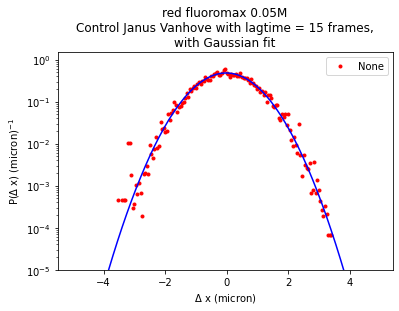

In [38]:
# Curve fit a Gaussian to the Vanhoves
if doing_control:
    control_janus_params, control_janus_covm = sco.curve_fit(gaussian, trackshist_control_janus_lg6_norm.index,
                                                                trackshist_control_janus_lg6_norm.values)
    control_janus_yfit = gaussian(trackshist_control_janus_lg6_norm.index, control_janus_params[0],
                                   control_janus_params[1], control_janus_params[2])

    trackshist_control_janus_lg6_norm.plot(style = 'r.')
    plt.plot(trackshist_control_janus_lg6_norm.index, control_janus_yfit, color = 'b')

    plt.yscale('log')
    plt.title(movie_name + '\nControl Janus Vanhove with lagtime = ' + str(vanhove_lagtime) + ' frames,\nwith Gaussian fit')
    plt.legend()
    plt.ylabel('P($\Delta$ x) (micron)$^{-1}$')
    plt.xlabel('$\Delta$ x (micron)')
    plt.ylim(ymin = 1e-5)

C:\Users\rsmolars\Anaconda3\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


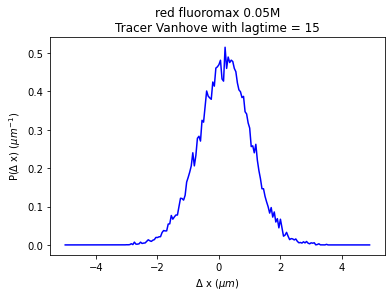

In [50]:
# Based on my previous code, I suspect the commands will be something like:

## reorder tracks by frame number
if doing_fueled:
    tracksbyframe_fueled_tracer = fueled_tracer_nodrift.set_index(['frame','particle'])['x'].unstack()
if doing_control:
    tracksbyframe_control_tracer = control_tracer_nodrift.set_index(['frame','particle'])['x'].unstack()
binsequence=np.arange(-vanhove_max_x,vanhove_max_x,binwidth)
## This makes a histogram of how far the particles traveled
#    You can choose the lagtime
if doing_fueled:
    trackshist_fueled_tracer_lg6 = tp.motion.vanhove(tracksbyframe_fueled_tracer, lagtime = vanhove_lagtime, mpp =
    scaling,bins = binsequence, ensemble = True)
if doing_control:
    trackshist_control_tracer_lg6 = tp.motion.vanhove(tracksbyframe_control_tracer, lagtime = vanhove_lagtime, mpp =
    scaling,bins = binsequence, ensemble = True)
"""
if doing_fueled:
    del tracksbyframe_fueled_tracer
if doing_control:
    del tracksbyframe_control_tracer
del binsequence
"""
if doing_fueled:
    trackshist_fueled_tracer_lg6_norm = manualnorm(trackshist_fueled_tracer_lg6)
if doing_control:
    trackshist_control_tracer_lg6_norm = manualnorm(trackshist_control_tracer_lg6)
if doing_fueled:
    trackshist_fueled_tracer_lg6_norm.plot(color = 'red')
if doing_control:
    trackshist_control_tracer_lg6_norm.plot(color = 'blue')
plt.title(movie_name + '\nTracer Vanhove with lagtime = ' + str(vanhove_lagtime))
plt.ylabel('P($\Delta$ x) ($\mu m^{-1}$)')
plt.xlabel('$\Delta$ x ($\mu m$)');

In [40]:
# Curve fit a Gaussian to the Vanhoves
if doing_fueled:
    fueled_tracer_params, fueled_tracer_covm = sco.curve_fit(gaussian, trackshist_fueled_tracer_lg6_norm.index,
                                                          trackshist_fueled_tracer_lg6_norm.values)
    fueled_tracer_yfit = gaussian(trackshist_fueled_tracer_lg6_norm.index, fueled_tracer_params[0],
                                 fueled_tracer_params[1], fueled_tracer_params[2])

    trackshist_fueled_tracer_lg6_norm.plot(style = 'r.')
    plt.plot(trackshist_fueled_tracer_lg6_norm.index, fueled_tracer_yfit, color = 'b')

    plt.yscale('log')
    plt.title(movie_name + '\nFueled Tracer Vanhove with lagtime = ' + str(vanhove_lagtime) + ' frames,\nwith Gaussian fit')
    plt.legend()
    plt.ylabel('P($\Delta$ x) ($\mu m^{-1}$)')
    plt.xlabel('$\Delta$ x ($\mu m$)')

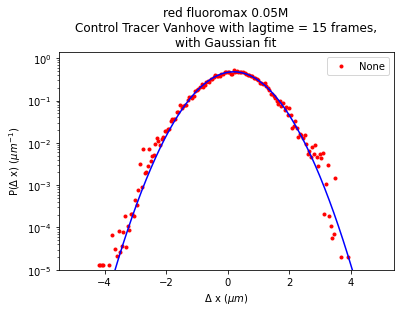

In [41]:
# Curve fit a Gaussian to the Vanhoves
if doing_control:
    control_tracer_params, control_tracer_covm = sco.curve_fit(gaussian, trackshist_control_tracer_lg6_norm.index,
                                                          trackshist_control_tracer_lg6_norm.values)
    control_tracer_yfit = gaussian(trackshist_control_tracer_lg6_norm.index, control_tracer_params[0],
                                 control_tracer_params[1], control_tracer_params[2])

    trackshist_control_tracer_lg6_norm.plot(style = 'r.')
    plt.plot(trackshist_control_tracer_lg6_norm.index, control_tracer_yfit, color = 'b')

    plt.yscale('log')
    plt.title(movie_name + '\nControl Tracer Vanhove with lagtime = ' + str(vanhove_lagtime) + ' frames,\nwith Gaussian fit')
    plt.legend()
    plt.ylabel('P($\Delta$ x) ($\mu m^{-1}$)')
    plt.xlabel('$\Delta$ x ($\mu m$)')
    plt.ylim(ymin = 1e-5)

(1e-06, 1.5863274472294528)

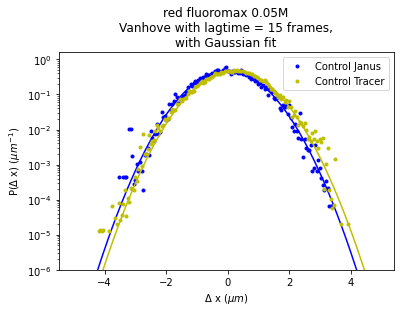

In [42]:
if doing_fueled:
    trackshist_fueled_janus_lg6_norm.plot(style = 'r.', label = 'Fueled Janus')
    plt.plot(trackshist_fueled_janus_lg6_norm.index, fueled_janus_yfit, color = 'r')
if doing_control:
    trackshist_control_janus_lg6_norm.plot(style = 'b.', label = 'Control Janus')
    plt.plot(trackshist_control_janus_lg6_norm.index, control_janus_yfit, color = 'b')
if doing_fueled:
    trackshist_fueled_tracer_lg6_norm.plot(style = 'g.', label = 'Fueled Tracer')
    plt.plot(trackshist_fueled_tracer_lg6_norm.index, fueled_tracer_yfit, color = 'g')
if doing_control:
    trackshist_control_tracer_lg6_norm.plot(style = 'y.', label = 'Control Tracer')
    plt.plot(trackshist_control_tracer_lg6_norm.index, control_tracer_yfit, color = 'y')

plt.yscale('log')
plt.title(movie_name + '\nVanhove with lagtime = ' + str(vanhove_lagtime) + ' frames,\nwith Gaussian fit')
plt.legend()
plt.ylabel('P($\Delta$ x) ($\mu m^{-1}$)')
plt.xlabel('$\Delta$ x ($\mu m$)')
plt.ylim(ymin=1e-6)

In [43]:
print('EXCESS KURTOSIS')
if doing_fueled:
    print('Fueled Janus: ' + str(trackshist_fueled_janus_lg6_norm.kurtosis()))
    metric3_fueled_janus = str(trackshist_fueled_janus_lg6_norm.kurtosis())
    print('Fueled Tracer: ' + str(trackshist_fueled_tracer_lg6_norm.kurtosis()))
    metric3_fueled_tracer = str(trackshist_fueled_tracer_lg6_norm.kurtosis())
if doing_control:
    print('Control Janus: ' + str(trackshist_control_janus_lg6_norm.kurtosis()))
    metric3_control_janus = str(trackshist_control_janus_lg6_norm.kurtosis())
    print('Control Tracer: ' + str(trackshist_control_tracer_lg6_norm.kurtosis()))
    metric3_control_tracer = str(trackshist_control_tracer_lg6_norm.kurtosis())

EXCESS KURTOSIS
Control Janus: 0.7829994524629194
Control Tracer: 0.4960537279885022


<Figure size 432x288 with 0 Axes>

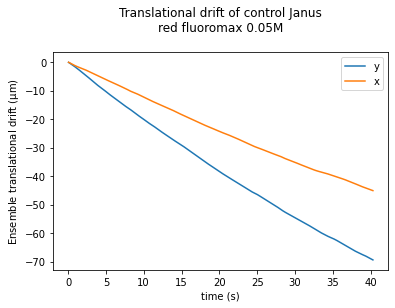

<Figure size 432x288 with 0 Axes>

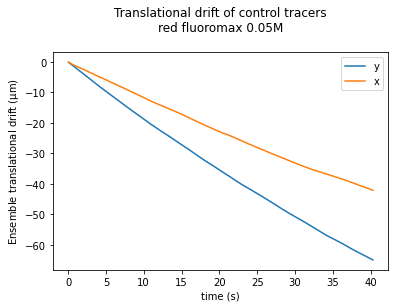

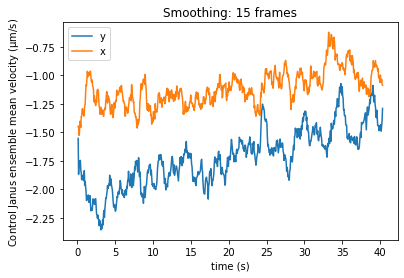

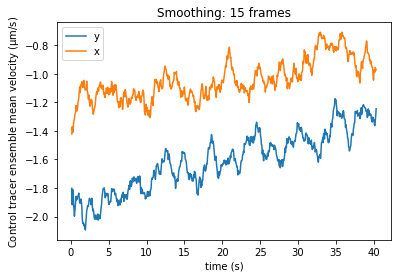

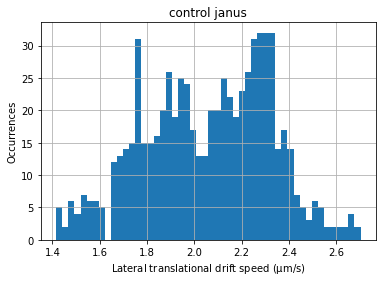

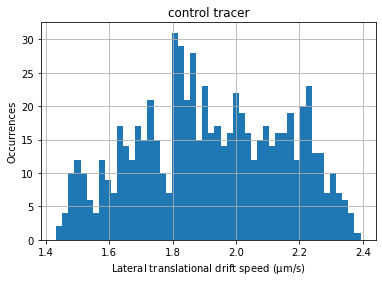

In [44]:
## View translational drift (though we use rotational drift for drift subtraction)
smoothing = 15 # frames

if doing_control:
    drift_control_janus = tp.compute_drift(control_janus, smoothing)*scaling
    drift_control_tracer = tp.compute_drift(control_tracer, smoothing)*scaling

    # Convert from frames to seconds
    drift_control_janus.index = drift_control_janus.index /fps
    drift_control_tracer.index = drift_control_tracer.index /fps
    drift_control_janus.index.name = 'time (s)'
    drift_control_tracer.index.name = 'time (s)'
    
    plt.figure()
    drift_control_janus.plot(grid=False)
    plt.title('Translational drift of control Janus\n' + movie_name + '\n')
    plt.ylabel('Ensemble translational drift ($\mathrm{\mu}$m)')
    #plt.xlabel('seconds')
    
    plt.figure()
    drift_control_tracer.plot(grid=False)
    plt.title('Translational drift of control tracers\n' + movie_name + '\n')
    plt.ylabel('Ensemble translational drift ($\mathrm{\mu}$m)')
       
    motion_control_janus = drift_control_janus.diff()
    velocity_control_janus_df = (drift_control_janus.diff()/ (1/fps))
    velocity_control_janus_df.plot()
    plt.ylabel("Control Janus ensemble mean velocity ($\mathrm{\mu}$m/s)")
    plt.title('Smoothing: ' + str(smoothing) + " frames")
    
    
    motion_control_tracer = drift_control_tracer.diff()
    velocity_control_tracer_df = (drift_control_tracer.diff()/ (1/fps))
    velocity_control_tracer_df.plot()
    plt.ylabel("Control tracer ensemble mean velocity ($\mathrm{\mu}$m/s)")
    plt.title('Smoothing: ' + str(smoothing) + " frames")
    
    ## Add speed to dataframes
    velocity_control_janus_df['speed'] = sqrt(velocity_control_janus_df.x**2 + velocity_control_janus_df.y**2)
    velocity_control_tracer_df['speed'] = sqrt(velocity_control_tracer_df.x**2 + velocity_control_tracer_df.y**2)
    
    plt.figure()
    velocity_control_janus_df.speed.hist(bins=50, label="control janus")
    plt.xlabel("Lateral translational drift speed ($\mathrm{\mu}$m/s)")
    plt.ylabel("Occurrences")
    plt.title("control janus")
    
    plt.figure()
    velocity_control_tracer_df.speed.hist(bins=50, label="control tracer")
    plt.xlabel("Lateral translational drift speed ($\mathrm{\mu}$m/s)")
    plt.ylabel("Occurrences")
    plt.title("control tracer")
    
if doing_fueled:
    drift_fueled_janus = tp.compute_drift(fueled_janus, smoothing)*scaling
    drift_fueled_tracer = tp.compute_drift(fueled_tracer, smoothing)*scaling
    
    # Convert from frames to seconds
    drift_fueled_janus.index = drift_fueled_janus.index /fps
    drift_fueled_tracer.index = drift_fueled_janus.index /fps
    drift_fueled_janus.index.name = 'time (s)'
    drift_fueled_tracer.index.name = 'time (s)'
    
    plt.figure()
    drift_fueled_janus.plot(grid=False)
    plt.title('Translational drift of fueled Janus\n' + movie_name + '\n')
    plt.ylabel('Ensemble translational drift ($\mathrm{\mu}$m)')
    
    plt.figure()
    drift_fueled_tracer.plot(grid=False)
    plt.title('Translational drift of fueled tracers\n' + movie_name + '\n')
    plt.ylabel('Ensemble translational drift ($\mathrm{\mu}$m)')

    motion_fueled_janus = drift_fueled_janus.diff()
    velocity_fueled_janus_df = (drift_fueled_janus.diff()/ (1/fps))
    velocity_fueled_janus_df.plot()
    plt.ylabel("fueled Janus ensemble mean velocity ($\mathrm{\mu}$m/s)")
    plt.title('Smoothing: ' + str(smoothing) + " frames")
    
    motion_fueled_tracer = drift_fueled_tracer.diff()
    velocity_fueled_tracer_df = (drift_fueled_tracer.diff()/ (1/fps))
    velocity_fueled_tracer_df.plot()
    plt.ylabel("fueled tracer ensemble mean velocity ($\mathrm{\mu}$m/s)")
    plt.title('Smoothing: ' + str(smoothing) + " frames")

    ## Add speed to dataframes
    velocity_fueled_janus_df['speed'] = sqrt(velocity_fueled_janus_df.x**2 + velocity_fueled_janus_df.y**2)
    velocity_fueled_tracer_df['speed'] = sqrt(velocity_fueled_tracer_df.x**2 + velocity_fueled_tracer_df.y**2)
    
    plt.figure()
    velocity_fueled_janus_df.speed.hist(bins=50, label="fueled janus")
    xlabel("Lateral translational drift speed ($\mathrm{\mu}$m/s)")
    ylabel("Occurrences")
    plt.title("fueled janus")
    
    plt.figure()
    velocity_fueled_tracer_df.speed.hist(bins=50, label="fueled tracer")
    plt.xlabel("Lateral translational drift speed ($\mathrm{\mu}$m/s)")
    plt.ylabel("Occurrences")
    plt.title("fueled tracer")

In [45]:
if doing_fueled:
    print("fueled janus n: {0}".format(fueled_janus_fit.values[0,0]))
    print("fueled janus A: {0}".format(fueled_janus_fit.values[0,1]))
    print("fueled janus EXCESS KURTOSIS: {0}".format(str(metric3_fueled_janus)))
    print("fueled janus NUMBER OF PARTICLES AFTER FILTERING: {0}".format(metric4_fueled_janus))
if doing_control:
    print("control janus n: {0}".format(control_janus_fit.values[0,0]))
    print("control janus A: {0}".format(control_janus_fit.values[0,1]))
    print("control janus EXCESS KURTOSIS: {0}".format(str(metric3_control_janus)))
    print("control janus NUMBER OF PARTICLES AFTER FILTERING: {0}".format(metric4_control_janus))

if doing_fueled:
    print("fueled tracer n: {0}".format(fueled_tracer_fit.values[0,0]))
    print("fueled tracer A: {0}".format(fueled_tracer_fit.values[0,1]))
    print("fueled tracer EXCESS KURTOSIS: {0}".format(str(metric3_fueled_tracer)))
    print("fueled tracer NUMBER OF PARTICLES AFTER FILTERING: {0}".format(metric4_fueled_tracer))
if doing_control:
    print("control tracer n: {0}".format(control_tracer_fit.values[0,0]))
    print("control tracer A: {0}".format(control_tracer_fit.values[0,1]))
    print("control tracer EXCESS KURTOSIS: {0}".format(str(metric3_control_tracer)))
    print("control tracer NUMBER OF PARTICLES AFTER FILTERING: {0}".format(metric4_control_tracer))

control janus n: 0.9904084558978744
control janus A: 1.678647234872021
control janus EXCESS KURTOSIS: 0.7829994524629194
control janus NUMBER OF PARTICLES AFTER FILTERING: 1075
control tracer n: 1.0223692389331545
control tracer A: 1.8757055780875316
control tracer EXCESS KURTOSIS: 0.4960537279885022
control tracer NUMBER OF PARTICLES AFTER FILTERING: 6140


In [46]:
### This section is for making the movie trajectories. 
# These serve two essential purposes:
# (1) Convincing us that we tracked the particles. 
# (2) Convincing other people that we tracked the particles.

# Assumes all videos have the same pixel length and width
if doing_control:
    (y_size,x_size) = control_green[0].shape
else:
    (y_size,x_size) = fueled_green[0].shape

new_movie_fps = 15   # doesn't have to be the same as fps
trajectory_folder = os.path.join(home, 'Trajectory')
movie_trajectory_folder = os.path.join(trajectory_folder, today, movie_name)

if (not os.path.exists(trajectory_folder)):
    os.mkdir(trajectory_folder)
    print("Created " + trajectory_folder)
if (not os.path.exists(os.path.join(trajectory_folder, today))):
    os.mkdir(os.path.join(trajectory_folder, today))
    print("Created " + os.path.join(trajectory_folder, today))
if (not os.path.exists(movie_trajectory_folder)):
    os.mkdir(movie_trajectory_folder)
    print("Created " + movie_trajectory_folder)
    
gc.collect()

Created C:\Users\rsmolars\Desktop\Trajectory\2022-10-14
Created C:\Users\rsmolars\Desktop\Trajectory\2022-10-14\red fluoromax 0.05M


59344

In [47]:
## Set constants

## Aesthetics
scalebar_greyscale = '0.5' # a higher number is more white. Choose something that contrasts with your movie.
scalebar_transparency = 0.75
trajectory_transparency = 0.4  ## 0 is completely transparent and 1 is completely opaque
particle_transparency = 0.2

fontsz=30

## Placement
scalebar_length_um = 15 # in microns
vertical_separation = 300
horizontal_separation = 50 # from left edge of movie to scalebar
text_bar_separation = 25
approx_length_of_text_px = 85
scalebar_height = 20
scalebar_bottom = x_size - vertical_separation
scalebar_top = scalebar_bottom - scalebar_height
scalebar_length_px = scalebar_length_um/scaling
scalebar_left_px = 0 + horizontal_separation              #scalebar_right_px - scalebar_length_px
scalebar_right_px = scalebar_left_px + scalebar_length_px #y_size-horizontal_separation
scalebar_left_percent = scalebar_left_px/(x_size*1.0)
#scalebar_length_percent = scalebar_length_px/(x_size*1.0)
#xmax = scalebar_length_percent + scalebar_left_percent
xmax = scalebar_right_px /(x_size*1.0)
center_of_bar = (scalebar_left_px + scalebar_right_px)/2.0
dpi = 72   # probably doesn't matter what this number is

frametime_sec = frametime/1000.0
moviegain=3

"""
Opens raw data frames from the disk, puts overlay over it,
writes new TIFF to disk. Memory semi-efficient :)

@param video_string - 'fueled' or 'control', tells function which TIFFs to open
@param name - filename of saved images
@param gain - multiply RGB values to better resolve particles from trajectories

@return None
"""
def make_movie_images_with_two_colors_new(video_string, name, gain=moviegain):
    green_particles, red_particles = (fueled_janus if video_string == 'fueled' else control_janus), (fueled_tracer if video_string == 'fueled' else control_tracer)
    green_tracks_to_show, red_tracks_to_show = green_particles['particle'].astype(int).unique(), red_particles['particle'].astype(int).unique()

   
    #length = len(os.listdir(movie_data_folder))
    frameno = 0
    
    for frame in sorted([item for item in np.sort(os.listdir(movie_data_folder)) if item.startswith(video_string)]):
        i = 0
        temp0 = tifffile.imread(os.path.join(movie_data_folder, frame))
        while i < len(temp0):
            #print(i)
            temp = temp0[i]
            #print(temp.shape)
            imagewidth=temp.shape[1]/dpi # calculate image width in inches
            imageheight=imagewidth*(temp.shape[0]/temp.shape[1])
            #print(imagewidth, imageheight)
            trajectorymovieframesize=[imagewidth,imageheight]

            fig = plt.figure(figsize=trajectorymovieframesize, frameon=False)
            #print(temp)
            ax = fig.add_axes([0,0,1,1])

            implot = ax.imshow(gain*temp)

            green_traj_hist = green_particles[green_particles.frame <= frameno]

            for this_particle in green_tracks_to_show:
                this_traj_hist = green_traj_hist[green_traj_hist.particle == this_particle]
                this_xcoords_hist = this_traj_hist['x']
                this_ycoords_hist = this_traj_hist['y']
                plot(this_xcoords_hist.values,this_ycoords_hist.values, 'g-', alpha=trajectory_transparency)

            #thisframefavcoords = green_particles[green_particles.frame == frameno]
            #xcoords, ycoords = thisframefavcoords['x'], thisframefavcoords['y']
            #plot(xcoords.values, ycoords.values, 'r.', alpha=particle_transparency)
            
            red_traj_hist = red_particles[red_particles.frame <= frameno]
            
            for this_particle in red_tracks_to_show:
                this_traj_hist = red_traj_hist[red_traj_hist.particle == this_particle]
                this_xcoords_hist = this_traj_hist['x']
                this_ycoords_hist = this_traj_hist['y']
                plot(this_xcoords_hist.values,this_ycoords_hist.values, 'r-', alpha=trajectory_transparency)

            #thisframefavcoords = red_particles[green_particles.frame == frameno]
            #xcoords, ycoords = thisframefavcoords['x'], thisframefavcoords['y']
            #plot(xcoords.values, ycoords.values, 'r.', alpha=particle_transparency)

            # scalebar
            plt.axhspan(scalebar_top, 
                    scalebar_top + scalebar_height, 
                    xmin=scalebar_left_percent, 
                    xmax=xmax,
                    color=scalebar_greyscale, 
                    alpha=scalebar_transparency)

            # scalebar label
            plt.text(center_of_bar-approx_length_of_text_px/2,scalebar_top-text_bar_separation, 
                 str(scalebar_length_um) + u' \u03bcm',
                 fontsize=fontsz,
                 color=scalebar_greyscale)

            # time stamp
            plt.text(horizontal_separation, horizontal_separation, "{:.1f}".format(frameno*frametime_sec) + ' sec',
                 fontsize=fontsz,
                 color=scalebar_greyscale)

            plt.ylim(y_size,0)
            plt.xlim(0,x_size)
            plt.xticks([],'')
            plt.yticks([],'')

            plt.savefig(os.path.join(movie_trajectory_folder, name + '_' + str(frameno).zfill(4) +'.tif'),
                   dpi = dpi)       

            temp0[i] = 0
            del temp
            i += 1
            frameno += 1
            
            close()
            
        
        del temp0
        gc.collect()

In [48]:
""" 
Overlays only one group of particle trajectories over a TIFF and writes to disk.

@param particles - the pandas dataframe of particle trajectories
@param frames - the TIFF stack of particle motion
@param name - the name of the images being written on the disk
@param gain - multiply RGB values to better resolve particles from trajectories

@return None
"""
def make_movie_images_with_one_color(particles, frames, name, gain=1):
    tracks_to_show = particles['particle'].astype(int).unique()

    # Calculate image width and height in inches.
    imagewidth=frames.shape[2]/dpi # calculate image width in inches
    imageheight=imagewidth*(frames.shape[1]/frames.shape[2])
    trajectorymovieframesize=[imagewidth,imageheight]
    
    # Thanks to Becca Perry for helping me with this code.
    for i in range(len(frames)): 
        #print(i)
        fig = plt.figure(figsize=trajectorymovieframesize,frameon=False)
        ax = fig.add_axes([0,0,1,1])

        implot = ax.imshow(gain*frames[i])

        traj_hist =  particles[particles.frame <=i]

        for this_particle in tracks_to_show:
            this_traj_hist = traj_hist[traj_hist.particle == this_particle]
            this_xcoords_hist = this_traj_hist['x']
            this_ycoords_hist = this_traj_hist['y']
            plt.plot(this_xcoords_hist.values,this_ycoords_hist.values, 'r-', alpha=0.4)

        thisframefavcoords = particles[particles.frame ==i]
        plt.xcoords = thisframefavcoords['x']
        plt.ycoords = thisframefavcoords['y']
        plt.plot(xcoords.values,ycoords.values, 'r.', alpha=0.2)

        # scalebar
        plt.axhspan(scalebar_top, 
                scalebar_top + scalebar_height, 
                xmin=scalebar_left_percent, 
                xmax=xmax,
                color=scalebar_greyscale, 
                alpha=0.75)

        # scalebar label
        plt.text(center_of_bar-approx_length_of_text_px/2,scalebar_top-text_bar_separation, 
             str(scalebar_length_um) + u' \u03bcm',
             fontsize=fontsz,
             color=scalebar_greyscale)

        # time stamp
        plt.text(horizontal_separation, horizontal_separation, "{:.1f}".format(i*frametime_sec) + ' sec',
             fontsize=fontsz,
             color=scalebar_greyscale)

        plt.ylim(y_size,0)
        plt.xlim(0,x_size)
        plt.xticks([],'')
        plt.yticks([],'')

        plt.savefig(os.path.join(movie_trajectory_folder, name + '_' + str(i).zfill(4) +'.tif'),
               dpi = fig.dpi)

        if i < len(frames)-1:
            close()

NameError: name 'xcoords' is not defined

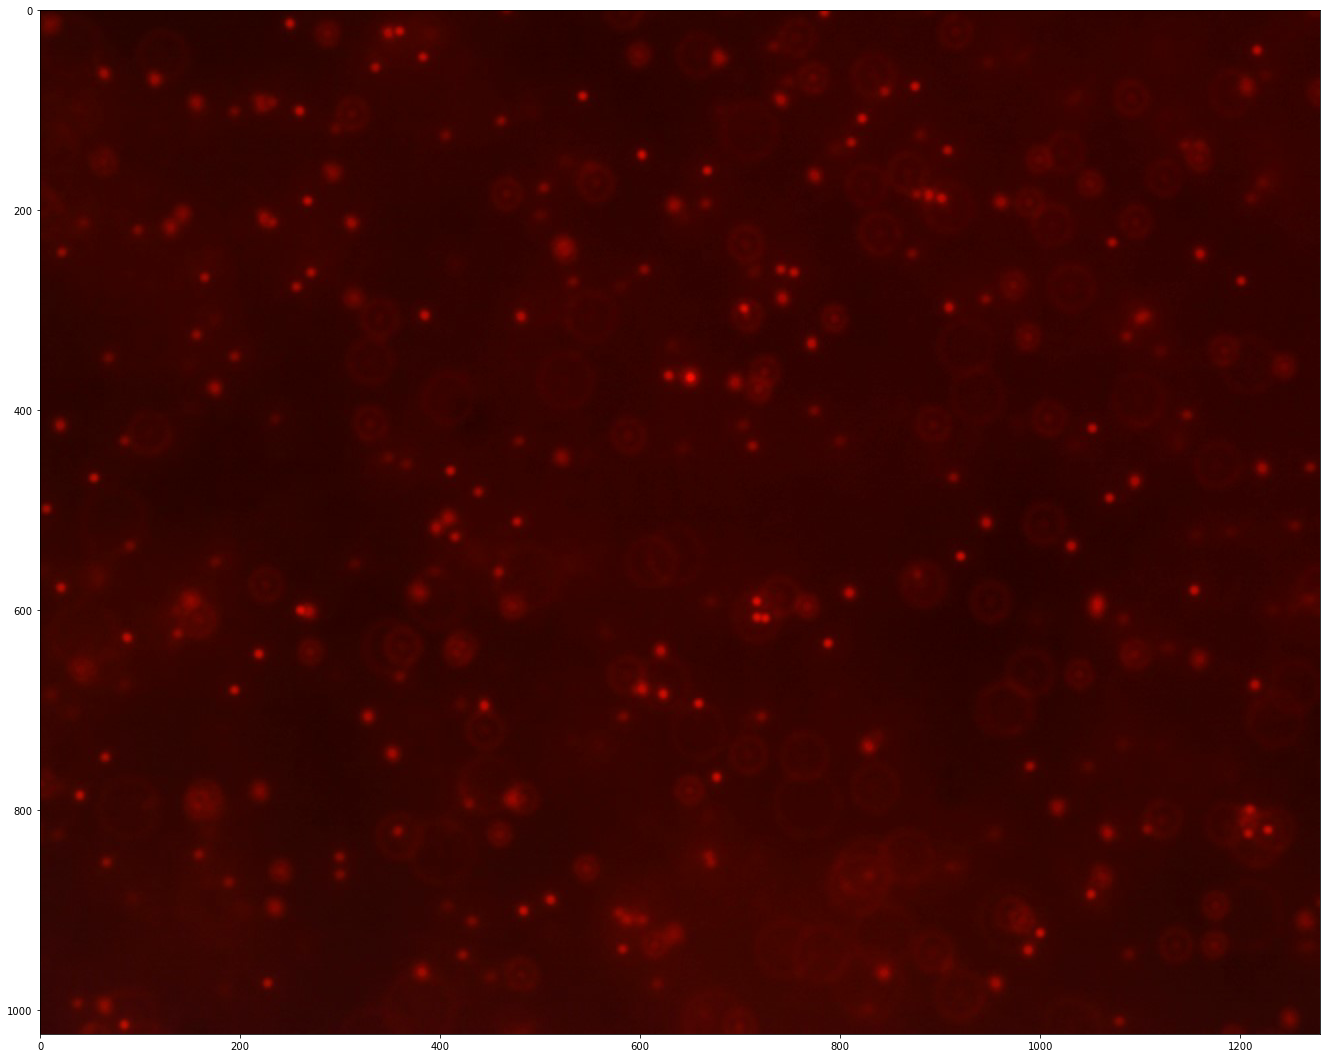

In [49]:
if doing_control:
    make_movie_images_with_one_color(particles = control_tracer,  frames=pims.Video(control_file), 
                                     name='Ryans movie', gain=1)
    

In [ ]:
if doing_fueled:
    make_movie_images_with_two_colors_new(video_string = 'fueled', name = 'fueled')

In [ ]:
if doing_control:
    make_movie_images_with_two_colors_new(video_string = 'control', name = 'control')    

In [ ]:
import cv2

using_tif = False


"""
Open the recently written TIFFs with overlay and stitch them into an .avi file.

@param name - 'fueled' vs 'control'; which images to read.
@return None
"""
def make_movie_video(name):
    os.chdir(movie_trajectory_folder)
    if using_tif:
        print('Looking in folder:', movie_trajectory_folder)
        images = [img for img in np.sort(os.listdir(movie_trajectory_folder)) if (img.startswith(name) and img.endswith('.tif'))]
        frame = cv2.imread(os.path.join(movie_trajectory_folder, images[0]))

    else:
        images = pims.Video(control_file)
        frame = images[0]
    height, width, layers = frame.shape

    video = cv2.VideoWriter(name + ".avi", 0, 15, (width, height))
    print('Saved:', str(name) + '.avi')

    
    for image in images:
        video.write(cv2.imread(os.path.join(movie_trajectory_folder, image)))
        #os.remove(os.path.join(movie_trajectory_folder, image))
    

    cv2.destroyAllWindows()
    video.release()

#Might only work with the .tif
if doing_fueled:
    make_movie_video(fueled_movie_filename)
if doing_control:
    make_movie_video('red_fluoromax_particles_PEG_200_0.05M_0')

os.chdir(home)

In [ ]:
gc.collect()